In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import os
from urllib import urlretrieve
import sys

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [3]:
# Load the information out of the json files
import json

def load_file_meta(filename):
    results = []
    with open(filename) as data_file:    
        data = json.load(data_file)
    
    for file_info in data:
        pic_info = {}
        pic_info['boxes'] = [{a : item[a] for a in ['top', 'left', 'height', 'width']}
                             for item in file_info['boxes']]
        pic_info['label'] = np.array([int(item['label']) % 10 for item in file_info['boxes']])
        pic_info['filename'] = file_info['filename']
        results.append(pic_info)
    return results
    
extra_info = load_file_meta('extra/digitStruct.json')

print("\n".join([str(a) for a in extra_info[:5]])) 

{'boxes': [{'width': 38.0, 'top': 70.0, 'height': 56.0, 'left': 24.0}, {'width': 36.0, 'top': 41.0, 'height': 56.0, 'left': 55.0}, {'width': 47.0, 'top': 23.0, 'height': 56.0, 'left': 79.0}], 'filename': u'1.png', 'label': array([4, 7, 8])}
{'boxes': [{'width': 94.0, 'top': 13.0, 'height': 203.0, 'left': 32.0}, {'width': 38.0, 'top': 33.0, 'height': 203.0, 'left': 143.0}], 'filename': u'2.png', 'label': array([7, 1])}
{'boxes': [{'width': 20.0, 'top': 5.0, 'height': 63.0, 'left': 18.0}, {'width': 33.0, 'top': 6.0, 'height': 63.0, 'left': 40.0}, {'width': 34.0, 'top': 18.0, 'height': 63.0, 'left': 72.0}], 'filename': u'3.png', 'label': array([1, 7, 4])}
{'boxes': [{'width': 23.0, 'top': 6.0, 'height': 38.0, 'left': 11.0}, {'width': 20.0, 'top': 6.0, 'height': 38.0, 'left': 35.0}], 'filename': u'4.png', 'label': array([3, 0])}
{'boxes': [{'width': 25.0, 'top': 9.0, 'height': 34.0, 'left': 8.0}, {'width': 17.0, 'top': 7.0, 'height': 34.0, 'left': 32.0}, {'width': 16.0, 'top': 5.0, 'height

************************************************************
Original (26, 42)


/home/brad/anaconda/lib/python2.7/site-packages/scipy/ndimage/interpolation.py:573: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


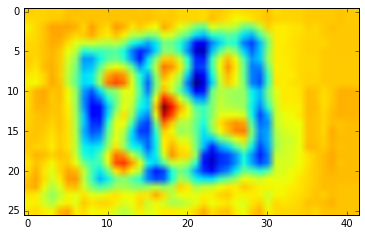

Zoomed (50, 80)


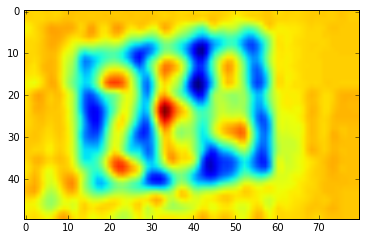

Cropped (45, 80)
Center 34.9206349206 21.5873015873


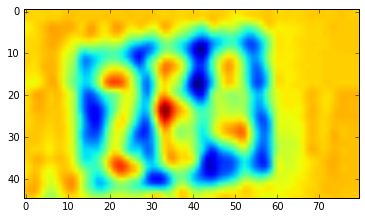

Filename:100001.png
Label:[2 6 4]
Color range: 0.5 -0.5
************************************************************
Original (83, 100)


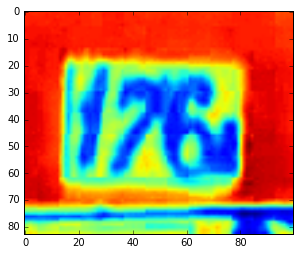

Zoomed (66, 80)


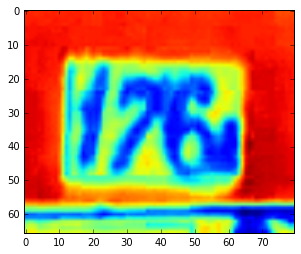

Cropped (45, 80)
Center 33.3333333333 33.3333333333


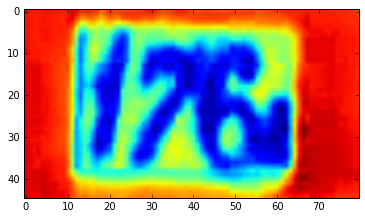

Filename:100002.png
Label:[1 7 6]
Color range: 0.5 -0.5
************************************************************
Original (55, 120)


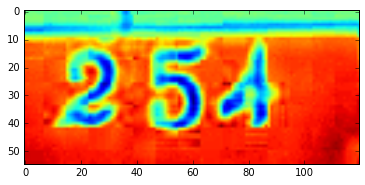

Zoomed (45, 98)


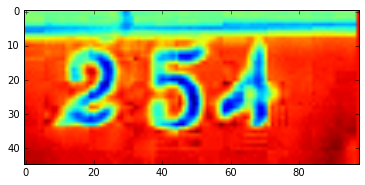

Cropped (45, 80)
Center 42.8181818182 22.3636363636


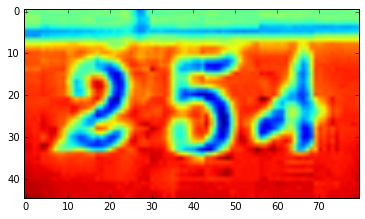

Filename:100003.png
Label:[2 5 4]
Color range: 0.5 -0.5
************************************************************
Original (89, 97)


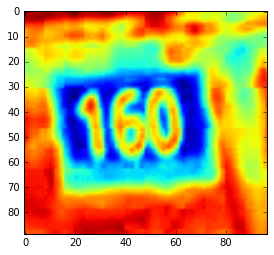

Zoomed (73, 80)


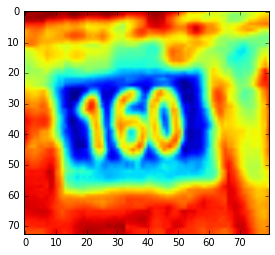

Cropped (45, 80)
Center 32.9896907216 36.0137457045


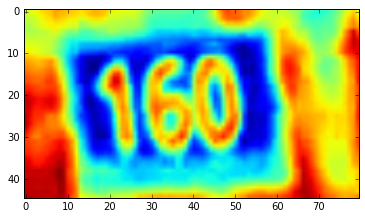

Filename:100004.png
Label:[1 6 0]
Color range: 0.5 -0.5
************************************************************
Original (86, 181)


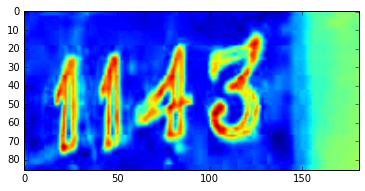

Zoomed (45, 95)


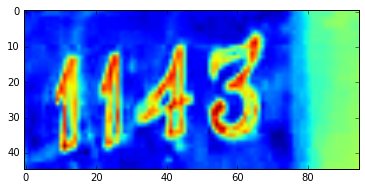

Cropped (45, 80)
Center 33.3575581395 23.2848837209


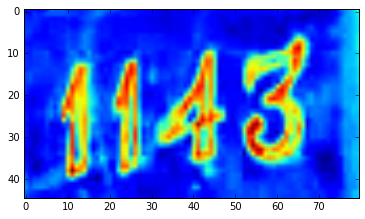

Filename:100005.png
Label:[1 1 4 3]
Color range: 0.5 -0.5
************************************************************
Original (61, 42)


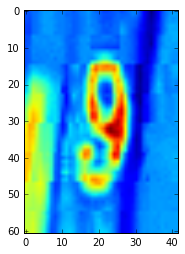

Zoomed (116, 80)


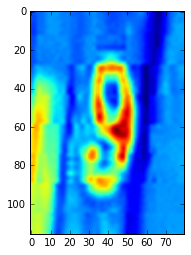

Cropped (45, 80)
Center 38.0952380952 60.9523809524


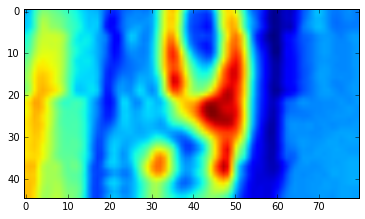

Filename:100006.png
Label:[9]
Color range: 0.5 -0.5
************************************************************
Original (64, 140)


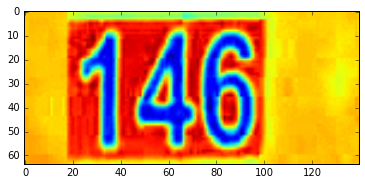

Zoomed (45, 98)


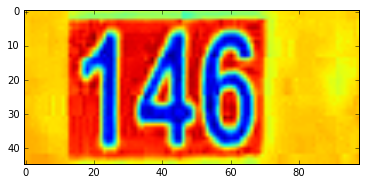

Cropped (45, 80)
Center 41.25 22.03125


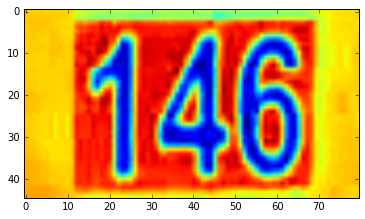

Filename:100007.png
Label:[1 4 6]
Color range: 0.5 -0.5
************************************************************
Original (49, 71)


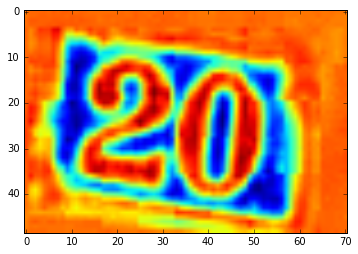

Zoomed (55, 80)


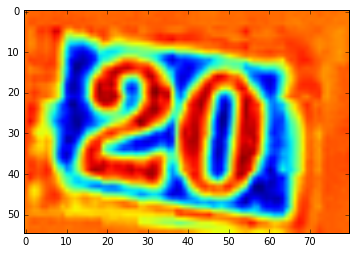

Cropped (45, 80)
Center 37.1830985915 28.7323943662


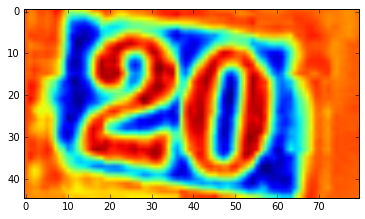

Filename:100008.png
Label:[2 0]
Color range: 0.5 -0.5
************************************************************
Original (84, 136)


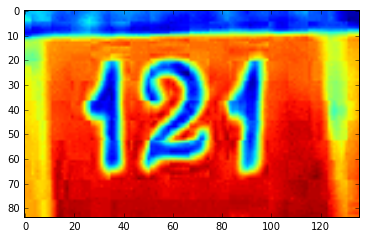

Zoomed (49, 80)


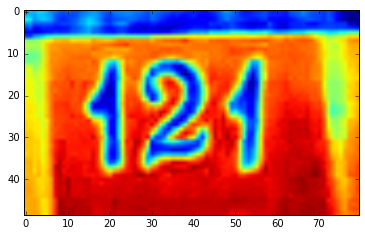

Cropped (45, 80)
Center 36.862745098 25.4901960784


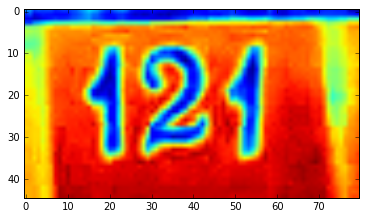

Filename:100009.png
Label:[1 2 1]
Color range: 0.5 -0.5
************************************************************
Original (74, 94)


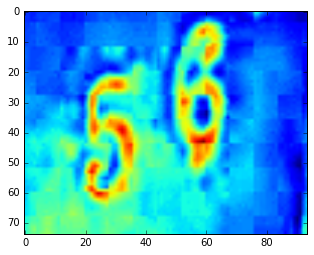

Zoomed (63, 80)


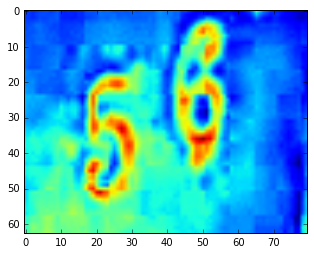

Cropped (45, 80)
Center 47.6595744681 22.1276595745


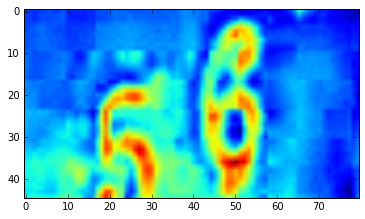

Filename:100010.png
Label:[6]
Color range: 0.5 -0.5


In [4]:
pixel_depth = 255.0  # Number of levels per pixel.
import os
from scipy import ndimage
import scipy.misc as spm
import scipy.ndimage as spn

img_width = 80
img_height = 45   

screen_ratio = 1. * img_height / img_width 
#screen_ratio = 1080./1920.

def pre_process_file(folder, pic_info, show=False):
    image_file = os.path.join(folder, pic_info['filename'])

    image_data = (ndimage.imread(image_file, flatten=True).astype(float) - 
                pixel_depth / 2) / pixel_depth

    ratio = 1.0 * image_data.shape[0] / image_data.shape[1]

    if ratio < screen_ratio:
        factor = 1.0 * img_height / image_data.shape[0]
    else:
        factor = 1.0 * img_width / image_data.shape[1]

    img = spn.interpolation.zoom(image_data, factor)

    # Center the picture around the bounding boxes as much as possible
    center_x = np.mean([box['left'] + (box['width'] // 2) for box in pic_info['boxes']]) * factor
    center_y = np.mean([box['top'] + (box['height'] // 2) for box in pic_info['boxes']]) * factor

    # The start x pos for copying the image
    s_x = int(center_x) - img_width // 2        
    if s_x < 0:
        s_x = 0
    elif s_x + img_width > img.shape[1]:
        s_x = img.shape[1] - img_width

    s_y = int(center_y) - img_height // 2
    if s_y < 0:
        s_y = 0
    elif s_y + img_height > img.shape[0]:
        s_y = img.shape[0] - img_height

    img_resized = img[s_y:s_y + img_height, s_x:s_x+img_width].astype(np.float32)

    img_colors = img_resized.astype(np.float32) - np.min(img_resized)
    img_colors = img_colors / np.max(img_colors) - 0.5

    if show:
        print('*' * 60)
        print("Original", image_data.shape)
        plt.imshow(image_data)
        plt.show()
        print("Zoomed", img.shape)
        plt.imshow(img)
        plt.show()
        print("Cropped", img_resized.shape)
        print("Center", center_x, center_y)
        plt.imshow(img_resized)
        plt.show()
        print("Filename:%s" % pic_info['filename'])
        print("Label:%s" % pic_info['label'])
        print("Color range:", np.max(img_colors), np.min(img_colors))

    return img_colors, pic_info['label']

for i in range(100000, 100010):
    pre_process_file('extra', extra_info[i], True)

In [5]:
from multiprocessing import Pool
from functools import partial


def pre_process_img_map(args):
    return pre_process_file(**args)


def generate_batch_parallel(folder, pic_info_list, show=False):
    """Load the data for a single letter label."""
    global started
    global finished
    started = 0
    finished = 0
    pool = Pool()    
    results = pool.map(partial(pre_process_file, folder), pic_info_list)
    pool.close()
    pool.join()
    
    imgs, labels = zip(*results)
    return np.array(imgs), np.array(labels)

In [6]:
%reset_selective -f tmp_.*

In [9]:
for folder, info in [('extra', extra_info)]:
    print("Generating:%s" % folder)
    dataset, labels = generate_batch_parallel(folder, info)
    
    print("Done %s, saving" % folder)
    pickle_file = 'SVHN_%s.pickle' % folder
    try:
      f = open(pickle_file, 'wb')
      save = {
        'dataset': dataset,
        'labels': labels,
        }
      pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
      f.close()
    except Exception as e:
      print('Unable to save data to', pickle_file, ':', e)
      raise
    statinfo = os.stat(pickle_file)
    print('Compressed pickle size:%dmb' % (statinfo.st_size // 1024**2))

Generating:extra
Done extra, saving
Unable to save data to SVHN_extra.pickle : error return without exception set


/home/brad/anaconda/lib/python2.7/site-packages/scipy/ndimage/interpolation.py:573: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
/home/brad/anaconda/lib/python2.7/site-packages/scipy/ndimage/interpolation.py:573: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
/home/brad/anaconda/lib/python2.7/site-packages/scipy/ndimage/interpolation.py:573: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
/home/brad/anaconda/lib/python2.7/site-packages/scipy/ndimage/interpolation.py:573: UserWarning: Fro

SystemError: error return without exception set

In [7]:
print(dataset.shape)
print(labels.shape)

NameError: name 'dataset' is not defined

In [8]:
folder = 'extra'
step = 20000
print("Done %s, saving" % folder)
for i in range(len(extra_info) // step):
    
    print("Generating:%d" % i)
    dataset, labels = generate_batch_parallel(folder, extra_info[i*step:(i+1)*step])
          
    pickle_file = 'SVHN_extra_%d.pickle' % i
    try:
      f = open(pickle_file, 'wb')
      save = {
        'dataset': dataset,
        'labels': labels,
        }
      pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
      f.close()
    except Exception as e:
      print('Unable to save data to', pickle_file, ':', e)
      raise
    statinfo = os.stat(pickle_file)
    print('Compressed pickle size:%dmb' % (statinfo.st_size // 1024**2))

Done extra, saving
Generating:0
Compressed pickle size:275mb
Generating:1
Compressed pickle size:275mb
Generating:2
Compressed pickle size:275mb
Generating:3
Compressed pickle size:275mb
Generating:4
Compressed pickle size:275mb
Generating:5
Compressed pickle size:275mb
Generating:6
Compressed pickle size:275mb
Generating:7
Compressed pickle size:275mb
Generating:8
Compressed pickle size:275mb
Generating:9
Compressed pickle size:275mb


Labels [2 3]
Dtype float32
Shape (45, 80)
Color range -0.5 0.5


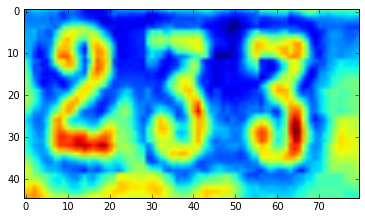

Labels [5 3 6]
Dtype float32
Shape (45, 80)
Color range -0.5 0.5


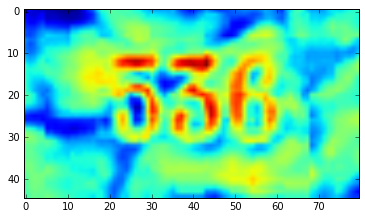

Labels [6 9]
Dtype float32
Shape (45, 80)
Color range -0.5 0.5


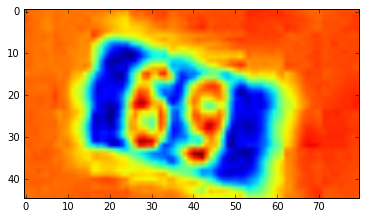

Labels [2 2 8]
Dtype float32
Shape (45, 80)
Color range -0.5 0.5


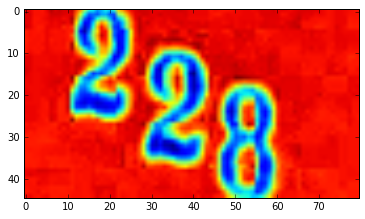

Labels [3 2]
Dtype float32
Shape (45, 80)
Color range -0.5 0.5


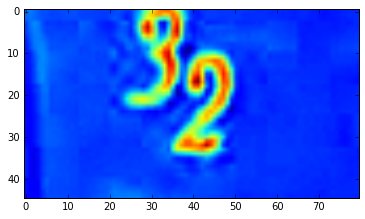

Labels [1 1 3]
Dtype float32
Shape (45, 80)
Color range -0.5 0.5


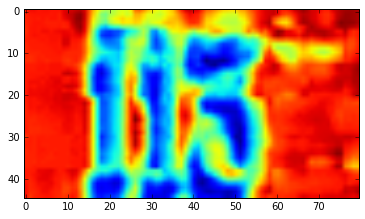

Labels [1 1 1]
Dtype float32
Shape (45, 80)
Color range -0.5 0.5


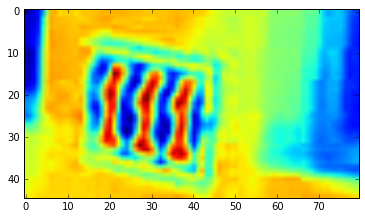

Labels [1 8 7]
Dtype float32
Shape (45, 80)
Color range -0.5 0.5


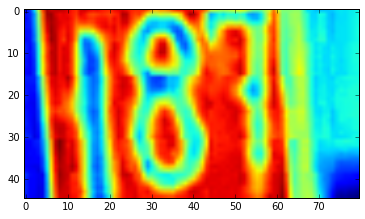

Labels [3 1]
Dtype float32
Shape (45, 80)
Color range -0.5 0.5


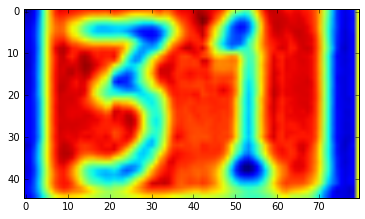

Labels [2 4 8]
Dtype float32
Shape (45, 80)
Color range -0.5 0.5


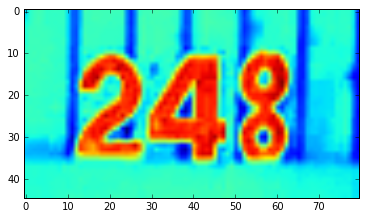

In [9]:
def show_image(img, label):
    print("Labels", label)
    print("Dtype", img.dtype)
    print("Shape", img.shape)
    print("Color range", np.min(img), np.max(img))
    if len(img.shape) > 2:
        plt.imshow(np.reshape(img, img.shape[:2]))
    else:
        plt.imshow(img)
    plt.show()
    
for i in range(10):
    show_image(save['dataset'][i], save['labels'][i])